# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [16]:
if os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    final_string_summary=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):#tqdm() is used to check how much % of loop is iterated and we can also see 
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # html tags are removed i the sentance by calling cleanhtml() function
        for w in sent.split():#spliting every every word in the sentance  
            for cleaned_words in cleanpunc(w).split():#puncuations are removed for every word the by calling cleanpunc() 
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):#isalpha() is a function used to check the word is alphabet or not     
                    if(cleaned_words.lower() not in stop):#all the words are lowered
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')#snowball steming for each word
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        final_string.append(str1)
        i+=1
        
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
    # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace',index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [19:16<00:00, 314.90it/s]


In [17]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [3]:
if os.path.isfile("final.sqlite"):
    conn = sqlite3.connect("final.sqlite")
    final = pd.read_sql_query("SELECT CleanedText FROM Reviews ORDER BY RANDOM() LIMIT 100000",conn)
    conn.close()

In [4]:
final_sample = final.sample(3000) 

# [4] Featurization

## [4.1] TF-IDF

In [6]:
tfidf = TfidfVectorizer(max_features = 3000)
tf = tfidf.fit_transform(final['CleanedText'].values)

In [7]:
tf.shape

(100000, 3000)

# [5] Assignment 11: Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [54]:
words = tfidf.get_feature_names()
# Displaying top 5 features
tfidf_mean = np.mean(tf, axis = 0)
tfidf_mean = np.array(tfidf_mean)[0].tolist()

In [9]:
topn_ids = np.argsort(tfidf_mean)[::-1]#[:3000]
top_feats = []
for i in topn_ids:
    top_feats.append([words[i], tfidf_mean[i]])
features = pd.DataFrame(top_feats)
features.columns = ['feature', 'tfidf_score']

In [10]:
features.head()

,feature,tfidf_score
0,tast,0.032083
1,like,0.030691
2,love,0.028699
3,great,0.028507
4,good,0.028467


In [11]:
top_features = features["feature"]

### [5.2] Calulation of Co-occurrence matrix

In [13]:
from scipy import zeros
arr = zeros([3000,3000])
df = pd.DataFrame(arr, index=words, columns=words)

In [14]:
df.head()

,abil,abl,absolut,absorb,acai,accept,access,accid,accident,accompani,...,yuck,yum,yummi,zero,zevia,zico,zing,zip,ziplock,zuke
abil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absolut,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
absorb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acai,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
for sent in tqdm(final['CleanedText']):
    words = sent.split(" ")
    for i in range(len(words)):
        for j in range(1,6):
            if(i + j < len(words) and words[i] != words[j]):
                try:
                    df.loc[words[i], words[j]] += 1 # If word i occurs in the proximity of word j add +1 to matrix.
                    df.loc[words[j], words[i]] += 1 # Same as above f+or word j
                except:
                    pass

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [5:07:59<00:00,  5.41it/s]


In [16]:
df.head()

,abil,abl,absolut,absorb,acai,accept,access,accid,accident,accompani,...,yuck,yum,yummi,zero,zevia,zico,zing,zip,ziplock,zuke
abil,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
abl,0.0,0.0,28.0,0.0,1.0,4.0,4.0,1.0,0.0,1.0,...,1.0,4.0,18.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0
absolut,0.0,28.0,0.0,2.0,1.0,1.0,2.0,4.0,3.0,1.0,...,1.0,3.0,28.0,5.0,3.0,2.0,1.0,1.0,0.0,0.0
absorb,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acai,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0


### [5.3] Finding optimal value for number of components (n) to be retained.

100%|██████████████████████████████████████████████████████████████████████████████████| 16/16 [07:50<00:00, 72.75s/it]


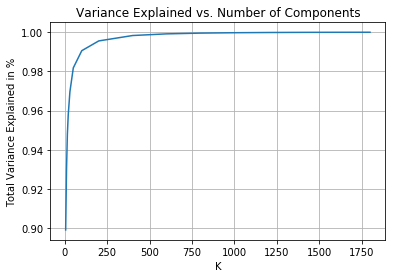

In [18]:
from sklearn.decomposition import TruncatedSVD
variance = []
k = [5,10,15,20,30,50,100,200,400,600,800,1000,1200,1400,1600,1800]
for comp in tqdm(k):
    svd = TruncatedSVD(n_components=comp)
    svd.fit(df)
    exp_var = svd.explained_variance_ratio_.sum()
    variance.append(exp_var)

# Plotting for best value of K
plt.plot(k, variance)
plt.title("Variance Explained vs. Number of Components")
plt.xlabel("K")
plt.ylabel("Total Variance Explained in %")
plt.grid()
plt.show()

In [19]:
svd = TruncatedSVD(n_components=500)
svd.fit(df)

TruncatedSVD(algorithm='randomized', n_components=500, n_iter=5,
       random_state=None, tol=0.0)

In [20]:
U = svd.transform(df)
VT =  svd.components_

In [21]:
svd.singular_values_.shape[0]

500

In [22]:
arr = np.zeros([500,500])
for i in range(500):
    arr[i, i] = svd.singular_values_[i]
Sigma = arr

In [24]:
print(" shape of matrix U:",U.shape,"\n","shape of sigma:", Sigma.shape,"\n","shape of V transporse:", VT.shape)

 shape of matrix U: (3000, 500) 
 shape of sigma: (500, 500) 
 shape of V transporse: (500, 3000)


### [5.4] Applying k-means clustering

In [25]:
from sklearn.cluster import KMeans
#import tqdm
squared_error_bow = []
#list_k = list(range(1, 10))
lst_k =[]

for k in range(2,11):
    km = KMeans(n_clusters=k,n_jobs =-1)
    km.fit(U)
    squared_error_bow.append(km.inertia_)
    lst_k.append(k)

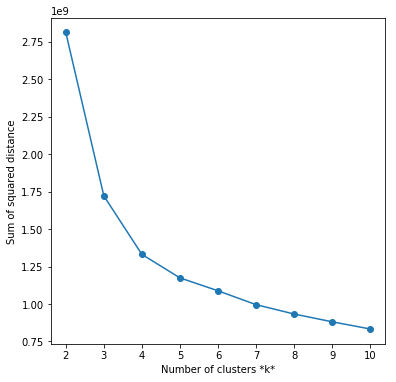

In [26]:
plt.figure(figsize=(6, 6))
plt.plot(lst_k, squared_error_bow, '-o')
plt.xlabel('Number of clusters *k*')
plt.ylabel('Sum of squared distance')
plt.show()

In [27]:
kmeans = KMeans(n_clusters=5,n_jobs=-1)
kmeans.fit(U)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [31]:
print(len(words))

18


In [32]:
Udf = pd.DataFrame(U)
Udf['labels'] = kmeans.labels_
#df = pd.DataFrame(top_feats)
Udf['words'] = top_feats
Udf.head()

,0,1,2,3,4,5,6,7,8,9,...,492,493,494,495,496,497,498,499,labels,words
0,53.823183,-5.522999,-8.444208,-0.940669,8.790673,-2.132931,6.745784,1.334469,-5.140023,-11.407294,...,1.042917,1.079332,-0.714431,-0.135175,-0.575823,-1.183643,-0.354324,0.910263,0,"[tast, 0.032082528584217916]"
1,1280.000075,93.575446,-31.381842,10.869803,-35.999124,-18.679907,235.869420,9.412692,32.761930,41.992984,...,-10.147677,-4.940988,0.913512,-2.133711,-4.557312,10.366268,-5.665911,9.379102,3,"[like, 0.030691200676876987]"
2,1774.032281,247.951271,30.776143,-5.669046,112.003407,-100.891968,-133.465671,67.061962,230.357041,15.398708,...,-5.230513,-2.863714,4.915516,7.913144,10.717595,-1.299142,0.700065,5.802656,3,"[love, 0.028699270249838316]"
3,75.010105,8.020780,1.377134,-2.263730,-16.752660,4.853297,9.296851,0.191620,2.290998,-10.933816,...,-0.368170,0.567575,-0.942649,2.316492,-0.252914,-0.971867,-1.579305,2.344564,0,"[great, 0.02850721036297781]"
4,138.804161,-36.687770,14.469822,-6.304913,-0.581521,-1.693637,-12.577440,-5.072234,-23.189728,-42.241619,...,3.982167,-3.881694,1.359312,0.227073,-7.797557,1.062846,3.897698,0.328876,0,"[good, 0.028466833001547773]"


### [5.5] Wordclouds of clusters obtained in the above section

In [34]:
labels = Udf["labels"]
words = Udf["words"]

In [36]:
type(words)

pandas.core.series.Series

In [39]:
print(words[3])

['great', 0.02850721036297781]


In [42]:
cluster0 = ''
cluster1 = ''
cluster2 = ''
cluster3 = ''
cluster4 = ''

for i in range(len(labels)):
    if labels[i]==0:
        cluster0 += " "+ words[i][0]
    elif labels[i]==1:
        cluster1 += " "+words[i][0]
    elif labels[i]==2:
        cluster2 += " "+words[i][0]
    elif labels[i]==3:
        cluster3 += " "+words[i][0]
    else:
        cluster4 += " "+words[i][0]

In [43]:
print(cluster1)

 dog bought made free peanut pasta per satisfi place market deliveri wife close part pet option microwav gummi truli complaint caramel summer general tin refriger jelli sea charg bear standard pocket load reorder contact zero countri spaghetti sugari youd frequent forev ridicul mexican kinda eas colleg rang haribo somewher hurt lamb creme minim celesti tropic america hey crap hydrogen diarrhea glaze hunt canada luckili harvest consumpt ignor vita gag neighborhood buckwheat exceed appropri nyc anybodi peac complement bene goji cooler tag merrick fluid nutmeg woman reli modifi oyster tremend ultra industri darjeel outdoor meow nope belov


cluster:0


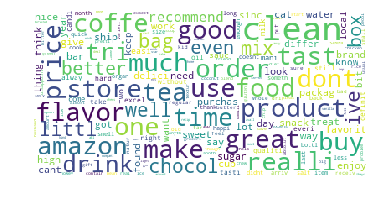

cluster:1


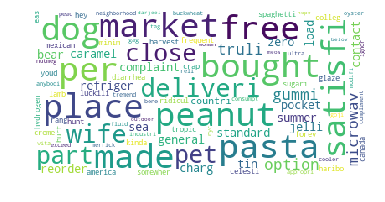

cluster:2


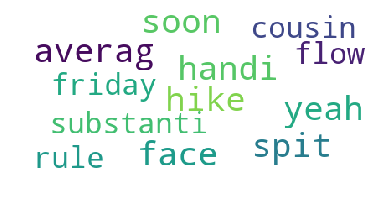

cluster:3


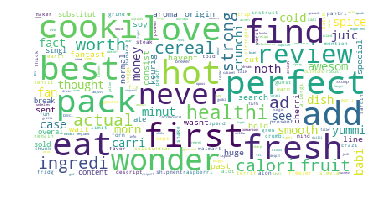

cluster:4


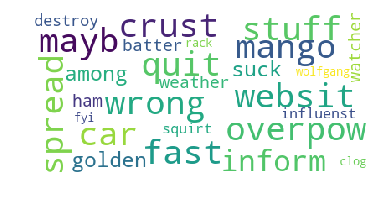

In [44]:
from wordcloud import WordCloud
#for i in range(4):
    # Generate WordCloud
wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cluster0)
print("cluster:0")
plt.imshow(wc)
plt.axis('off')
plt.show()

wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cluster1)
print("cluster:1")
plt.imshow(wc)
plt.axis('off')
plt.show()

wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cluster2)
print("cluster:2")
plt.imshow(wc)
plt.axis('off')
plt.show()

wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cluster3)
print("cluster:3")
plt.imshow(wc)
plt.axis('off')
plt.show()

wordcloud = WordCloud(background_color='white',max_font_size=40, random_state=42)
wc = wordcloud.generate(cluster4)
print("cluster:4")
plt.imshow(wc)
plt.axis('off')
plt.show()

### [5.6] Function that returns most similar words for a given word.

In [69]:
from sklearn.metrics.pairwise import cosine_similarity
def word_similarity(word):
    similar_words=[]
    similarity = cosine_similarity(U)
    word_vector = similarity[words.index(word)]
    index = word_vector.argsort()[::-1][1:11]
    for i in range(len(index)):
        similar_words.append(words[index[i]])
    print(similar_words)

In [72]:
word_similarity('like')

['better', 'without', 'want', 'way', 'definit', 'probabl', 'amaz', 'although', 'compar', 'truli']


# [6] Conclusions

- selecting the no.of componets in the truncatedSVD is most crusial part in my case with 700 components iam getting the 99% varience. if we incresse the size of the no.of components it simply incresse the time complexity.
- After doing truncatedSVD KMeans clusterinig tend to works well.
- The no.of components in truncatedSVD: 700
- The no.of clusters in KMeans:4